In [1]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import os
from datetime import date, time, datetime
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
#Loading the dataset from MongoDB
mongo_uri = os.getenv('MONGO_URI')
client = MongoClient(mongo_uri)
db = client['test']
collection= db['Procurement-AI-Agent']
data = pd.DataFrame(list(collection.find()))

In [4]:
# Remove mongodb's _id column
data = data.drop(columns='_id')

In [5]:
data.head(2)

,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Compliance,Defective_Units
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,Yes,NaN
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,Yes,235.0


In [6]:
#Fill NAs with 0
data= data.fillna(0)

In [7]:
# Transform date values to three seperate columns
data['Order_Date'] = pd.to_datetime(data['Order_Date'])
data['Oder_Day'] = pd.to_datetime(data['Order_Date']).dt.day
data['Oder_Month'] = pd.to_datetime(data['Order_Date']).dt.month
data['Oder_Year'] = pd.to_datetime(data['Order_Date']).dt.year

In [8]:
len(data['PO_ID'].value_counts().reset_index())

777

In [9]:
# Checking with Vendor and compliance reputations
data[['Supplier', 'Compliance']].value_counts().reset_index()

,Supplier,Compliance,count
0,Epsilon_Group,Yes,163
1,Alpha_Inc,Yes,132
2,Gamma_Co,Yes,123
3,Beta_Supplies,Yes,118
4,Delta_Logistics,Yes,104
5,Delta_Logistics,No,67
6,Beta_Supplies,No,38
7,Gamma_Co,No,20
8,Alpha_Inc,No,9
9,Epsilon_Group,No,3


In [10]:
# Not important but I want to know

data['Order_Status'].value_counts(normalize=True)

Order_Status
Delivered              0.720721
Pending                0.104247
Partially Delivered    0.093951
Cancelled              0.081081
Name: proportion, dtype: float64

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
data.select_dtypes(include='object').columns

Index(['PO_ID', 'Supplier', 'Delivery_Date', 'Item_Category', 'Order_Status',
       'Compliance'],
      dtype='object')

In [13]:
le = LabelEncoder()

for col in ['Supplier', 'Item_Category', 'Order_Status','Compliance']:
    data[f"encoded_{col}"] = le.fit_transform(data[col])

In [14]:
data.head(2)

,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Compliance,Defective_Units,Oder_Day,Oder_Month,Oder_Year,encoded_Supplier,encoded_Item_Category,encoded_Order_Status,encoded_Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,Yes,0.0,17,10,2023,0,2,0,1
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,Yes,235.0,25,4,2022,2,2,1,1


### Data Transformation Glossary

In [15]:
supplier = data.groupby('Supplier')['encoded_Supplier'].mean()
supplier

Supplier
Alpha_Inc          0.0
Beta_Supplies      1.0
Delta_Logistics    2.0
Epsilon_Group      3.0
Gamma_Co           4.0
Name: encoded_Supplier, dtype: float64

In [16]:
item_Category = data.groupby('Item_Category')['encoded_Item_Category'].mean()
item_Category

Item_Category
Electronics        0.0
MRO                1.0
Office Supplies    2.0
Packaging          3.0
Raw Materials      4.0
Name: encoded_Item_Category, dtype: float64

In [17]:
order_Status = data.groupby('Order_Status')['encoded_Order_Status'].mean()
order_Status

Order_Status
Cancelled              0.0
Delivered              1.0
Partially Delivered    2.0
Pending                3.0
Name: encoded_Order_Status, dtype: float64

In [18]:
compliance= data.groupby('Compliance')['encoded_Compliance'].mean()
compliance

Compliance
No     0.0
Yes    1.0
Name: encoded_Compliance, dtype: float64

In [19]:
processed = data.select_dtypes('number')

In [20]:
processed.columns

Index(['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units',
       'Oder_Day', 'Oder_Month', 'Oder_Year', 'encoded_Supplier',
       'encoded_Item_Category', 'encoded_Order_Status', 'encoded_Compliance'],
      dtype='object')

In [21]:
processed = processed[['encoded_Supplier','encoded_Item_Category', 'encoded_Order_Status', 'Oder_Day', 
           'Oder_Month', 'Oder_Year', 'Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units', 'encoded_Compliance']]

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import random

In [23]:
random.seed(42)

In [24]:
X = processed.drop(columns= 'encoded_Compliance')
y = processed['encoded_Compliance']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state= 42, stratify= y)

In [26]:
params = {
    "n_estimators": 350,              # More trees for stability
    "criterion": "gini",              # "gini" or "entropy" – both work, gini is faster
    "max_depth": None,                # Let trees grow fully unless overfitting
    "min_samples_split": 5,           # Prevents overfitting
    "min_samples_leaf": 2,            # Each leaf must have at least 2 samples
    "max_features": "sqrt",           # Common for classification tasks
    "bootstrap": True,                # Bootstrapping improves generalization
    "class_weight": "balanced",       # Handles imbalanced classes
    "random_state": 42,               # Reproducibility
    "n_jobs": -1,                     # Use all cores
    "verbose": 0                      # Set >0 to see training progress
}

In [27]:
rfModel = RandomForestClassifier(**params)

In [28]:
rfModel.fit(X_train, y_train)

,n_estimators,350
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
y_pred = rfModel.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.32      0.38        28
           1       0.86      0.91      0.89       128

    accuracy                           0.81       156
   macro avg       0.66      0.62      0.63       156
weighted avg       0.79      0.81      0.79       156



In [31]:
accuracy_score(y_test, y_pred)

0.8076923076923077

In [32]:
roc_auc_score(y_test, y_pred)

0.6177455357142857

In [33]:
average_precision_score(y_test, y_pred)

0.8568754124245852

In [34]:
y_prob = rfModel.predict_proba(X_test)[:,1]

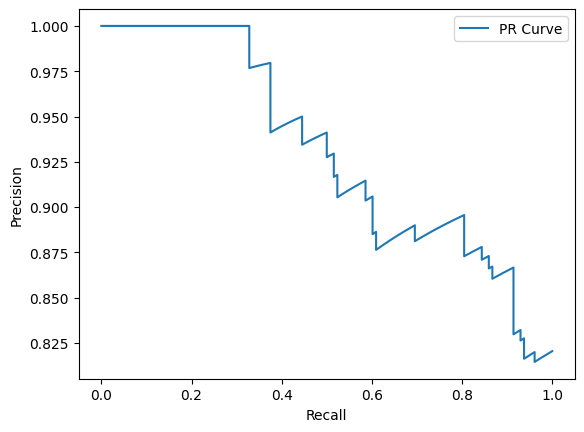

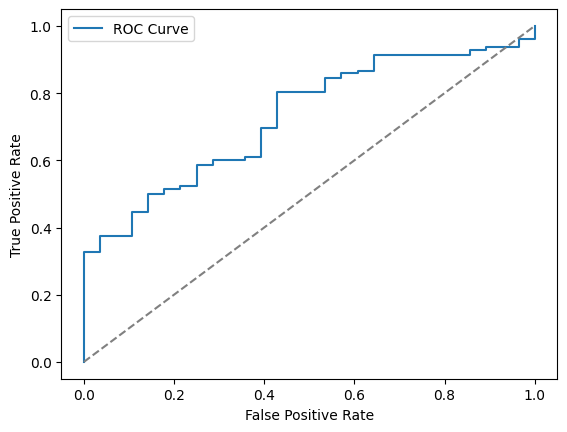

In [35]:
import matplotlib.pyplot as plt 

precision, recall, _ = precision_recall_curve(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.show()

plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()

In [36]:
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC:", average_precision_score(y_test, y_prob))

ROC AUC: 0.7282366071428571
PR AUC: 0.9305061127437217


In [37]:
data.head()

,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Compliance,Defective_Units,Oder_Day,Oder_Month,Oder_Year,encoded_Supplier,encoded_Item_Category,encoded_Order_Status,encoded_Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,Yes,0.0,17,10,2023,0,2,0,1
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,Yes,235.0,25,4,2022,2,2,1,1
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,Yes,41.0,26,1,2022,4,1,1,1
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,Yes,112.0,9,10,2022,1,3,1,1
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,No,171.0,8,9,2022,2,4,1,0


In [40]:
categories = data['Item_Category'].unique()
supplier = data['Supplier'].unique()

In [41]:
supplier

array(['Alpha_Inc', 'Delta_Logistics', 'Gamma_Co', 'Beta_Supplies',
       'Epsilon_Group'], dtype=object)